# K-degree constrained MST
Dato un grafo non orientato e non completo, e dato un nodo $r$, si determini l’albero di copertura di radice $r$ che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha $k_i$ ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di $k_i-1$)

Obiettivo:
$$\text{min}\ \sum_{i\in V}{\ \text{max}((k_i - 1),0)}$$

In [1]:
import os
import networkx as nx
from random import seed, randint
import time

from shared import *
from generators import generate_graph
from search_algorithms import tabu_search

In [2]:
# PARAMETRI GENERALI
OUT_DIR = "out/tabu" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 7
MAX_NODES = 326
GRAPH_GENERATOR = "NOT_BEST_PATH" # [ NX_COMPLETE | NX_DENSE | NX_RANDOM | DENSE | SPARSE | NOT_BEST_PATH ]
RANDOM_SEED = 191295

### Inizializzazione

In [3]:
# CREAZIONE GRAFO e strutture
G = generate_graph(GRAPH_GENERATOR=GRAPH_GENERATOR, MAX_NODES=MAX_NODES, seed=RANDOM_SEED)


# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Uso generatore di grafi a stella NOT_BEST_PATH
[INFO] Aggiunte  33  stelle al grafo di partenza.


## Tabu Search

La Tabu Search è un'evoluzione di Local Search che prosegue la ricerca dopo gli ottimi locali. Risultato: il migliore ottimo locale tra tutti quelli visitati

**Soluzione iniziale**: MST ammissibile generato con Kruskal/Prim o visita in profondità

    > visita in profondità genera (quasi) subito soluzioni molto buone su grafi densi

**Intorno**: Aggiungo un arco a MST. Rimuovo un arco del ciclo che si è creato per tornare nell'ammissibilità

**Diversificazione**: Penalizza le mosse proibite che non migliorano soluzione di |V| unità di costo

**Intensificazione**: \<TODO>

### 1. Creazione soluzione ammissibile

Parto da un MST subottimale ottenuto con Kruskal/Prim o la visita in ampiezza a partire dalla radice.

In [4]:
# Creazione di MST con radice specificata tramite visita in ampiezza
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

In [5]:
# Creazione di MST con radice specificata tramite visita in profondità

def build_depth_first_mst(graph, node):
    MST = nx.Graph()
    return recursive_depth_first(graph, node, MST)

def recursive_depth_first(graph, node, MST):
    # MST è una risorsa condivisa tra le ricorsioni
    # TODO: trovare un modo più elegante di aggiornarlo
    children = graph.adj[node]
    for child in children:
        if child not in MST.nodes:
            MST.add_edge(node, child)
            MST = recursive_depth_first(graph, child, MST)

    return MST

In [6]:
# Creazione soluzione iniziale
#mst = build_rooted_mst(G, ROOT_NODE)
mst = build_depth_first_mst(G, ROOT_NODE)
#mst = nx.algorithms.minimum_spanning_tree(G, algorithm="kruskal")

In [7]:
# PRINT INFO SOL. INIZIALE
print("Costo iniziale:", cost(mst, ROOT_NODE))
print("MST = ", mst.edges)

print("")
print("---DETTAGLI---")
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("graph is complete: ",(E == V*(V-1)/2))

Costo iniziale: 163
MST =  [(7, 0), (0, 1), (1, 8), (8, 2), (2, 10), (10, 4), (10, 268), (4, 9), (4, 168), (9, 5), (9, 208), (9, 273), (5, 19), (19, 17), (17, 12), (17, 218), (12, 3), (3, 11), (11, 13), (13, 15), (15, 14), (14, 21), (21, 25), (25, 26), (26, 22), (22, 18), (18, 28), (28, 80), (80, 83), (80, 178), (83, 44), (44, 33), (44, 188), (44, 313), (33, 20), (20, 32), (32, 23), (23, 16), (16, 34), (34, 51), (51, 46), (46, 29), (29, 40), (29, 114), (29, 152), (40, 48), (40, 233), (40, 308), (48, 41), (41, 35), (41, 258), (35, 36), (35, 91), (36, 63), (63, 39), (39, 24), (24, 27), (27, 6), (6, 79), (6, 238), (79, 56), (56, 37), (37, 45), (45, 30), (30, 58), (58, 50), (50, 31), (31, 38), (31, 66), (31, 86), (38, 43), (43, 53), (53, 64), (53, 183), (53, 203), (53, 288), (64, 95), (95, 59), (95, 104), (59, 73), (59, 138), (59, 263), (73, 121), (121, 115), (115, 67), (67, 60), (60, 57), (57, 75), (75, 68), (68, 78), (68, 155), (78, 76), (78, 142), (76, 88), (88, 65), (88, 133), (88, 243

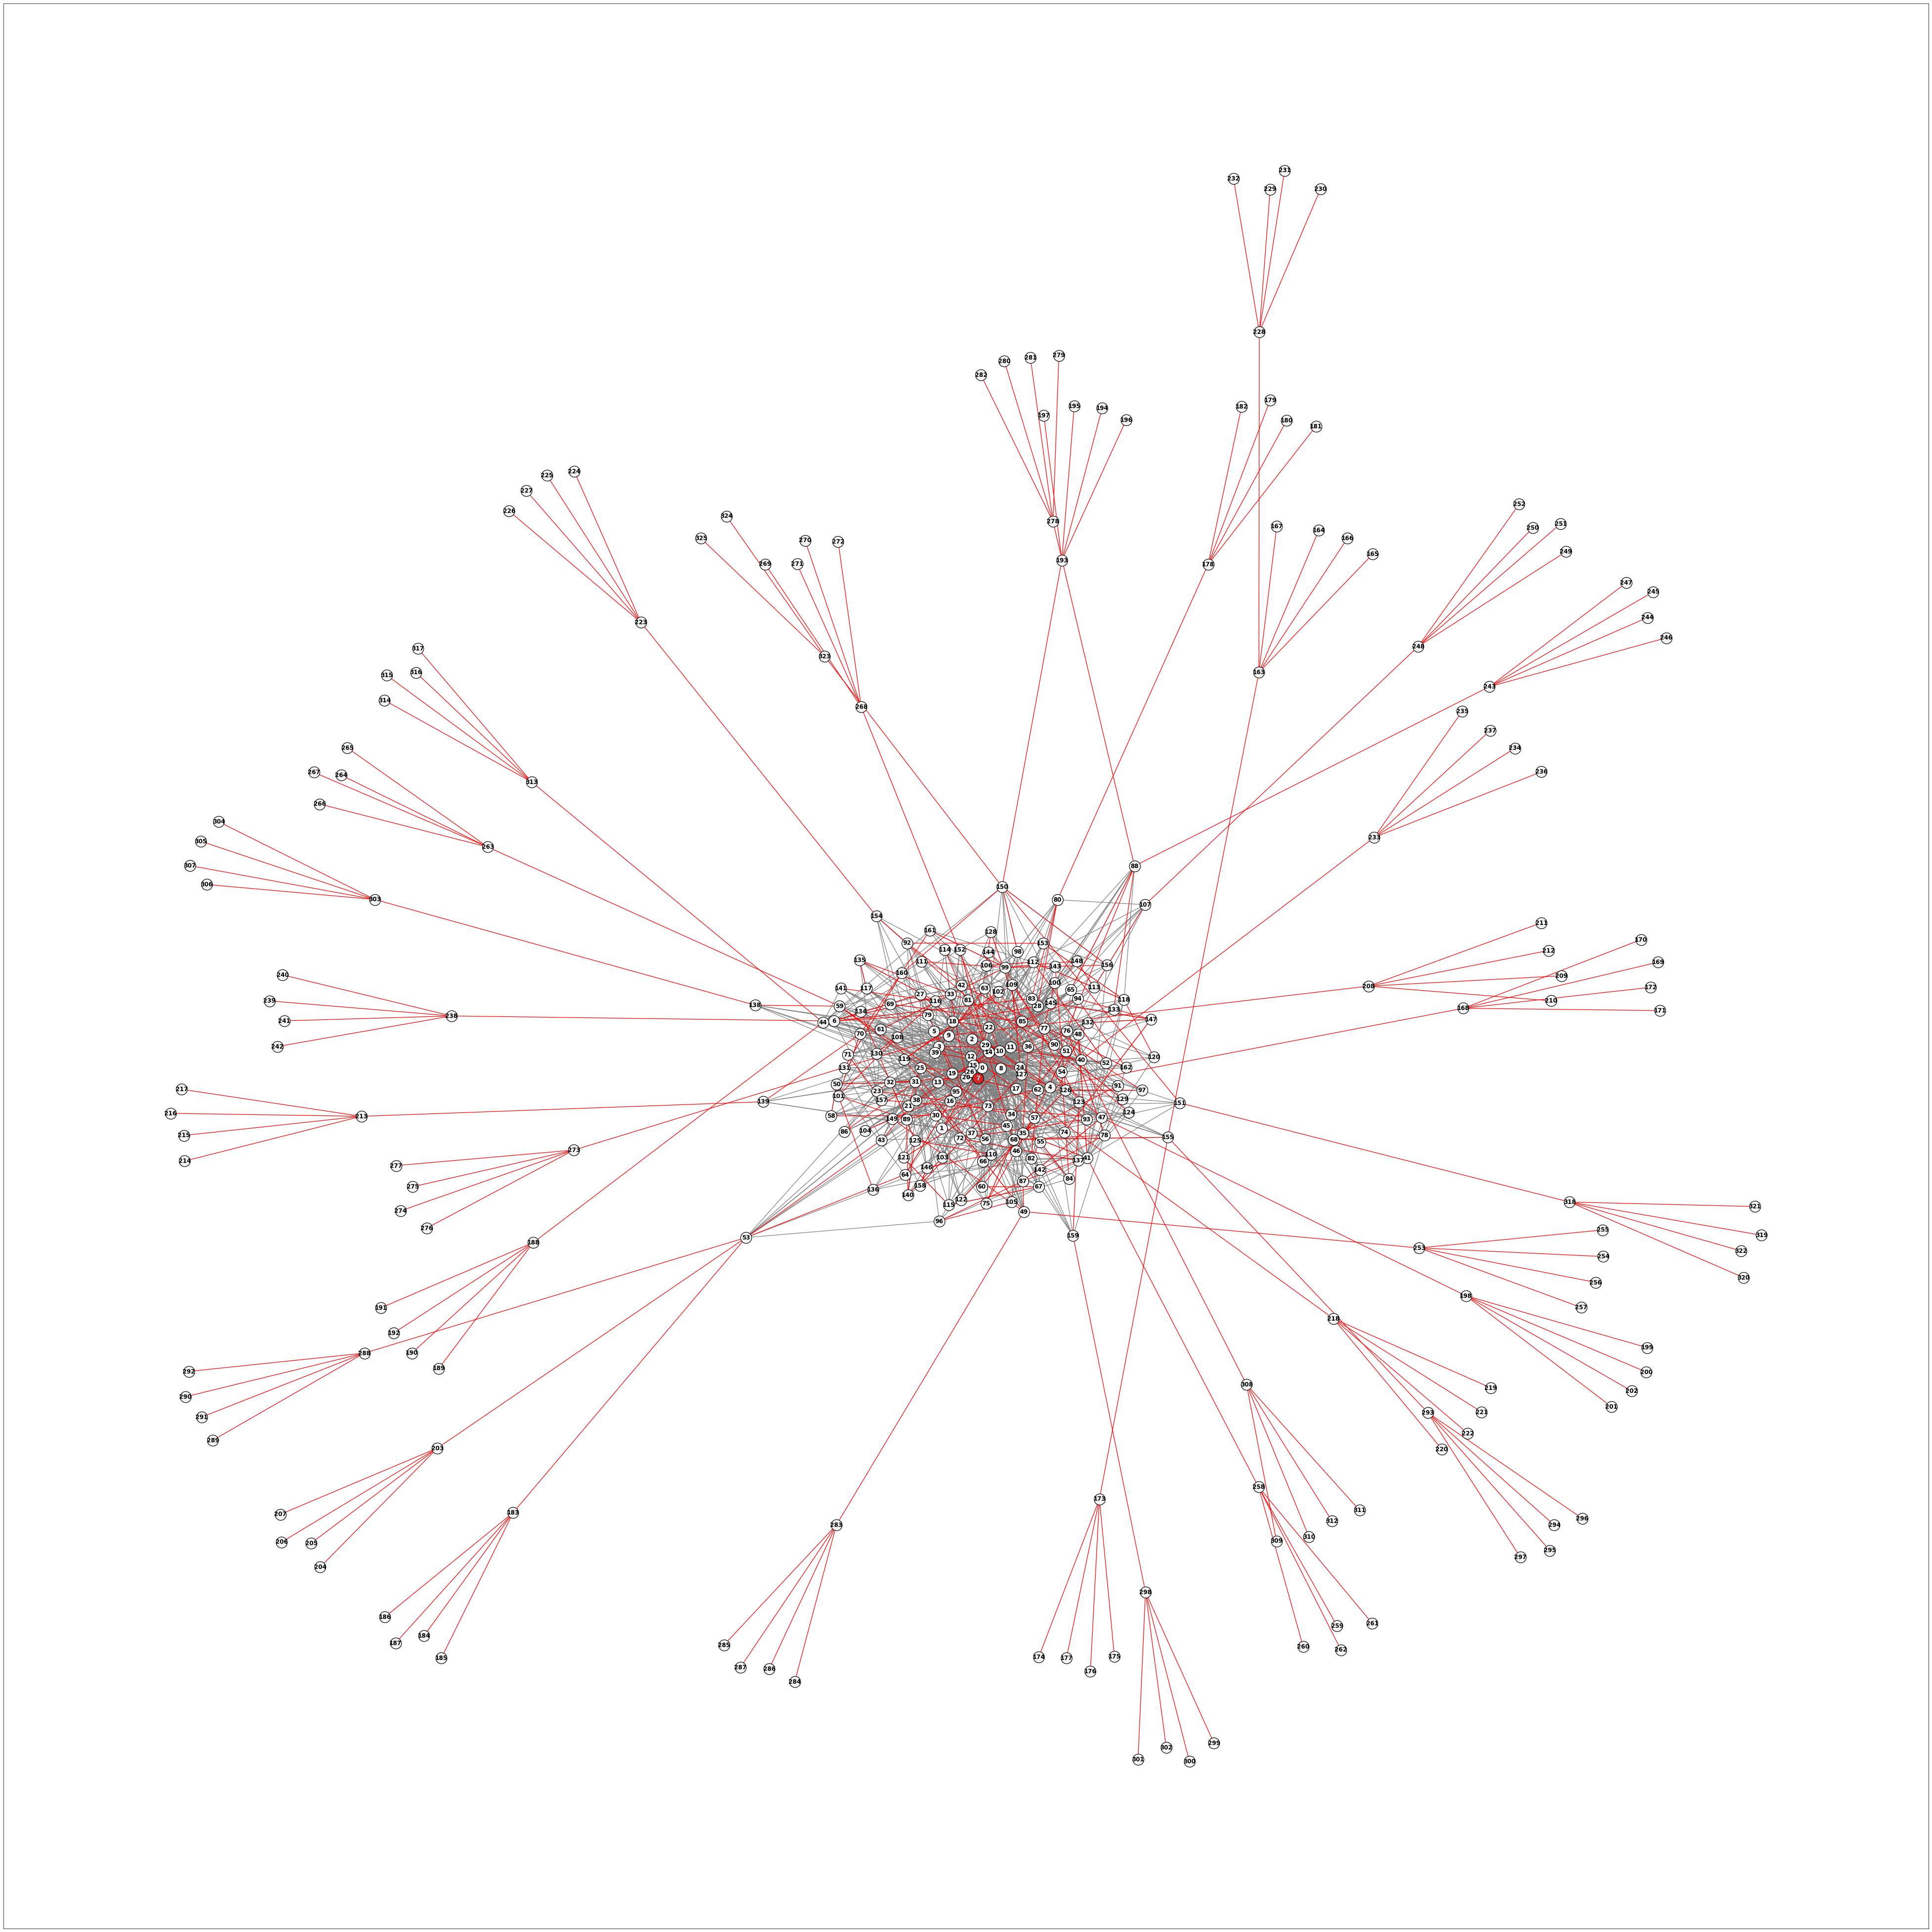

In [8]:
# RENDERING MST INIZIALE SUL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="initial")

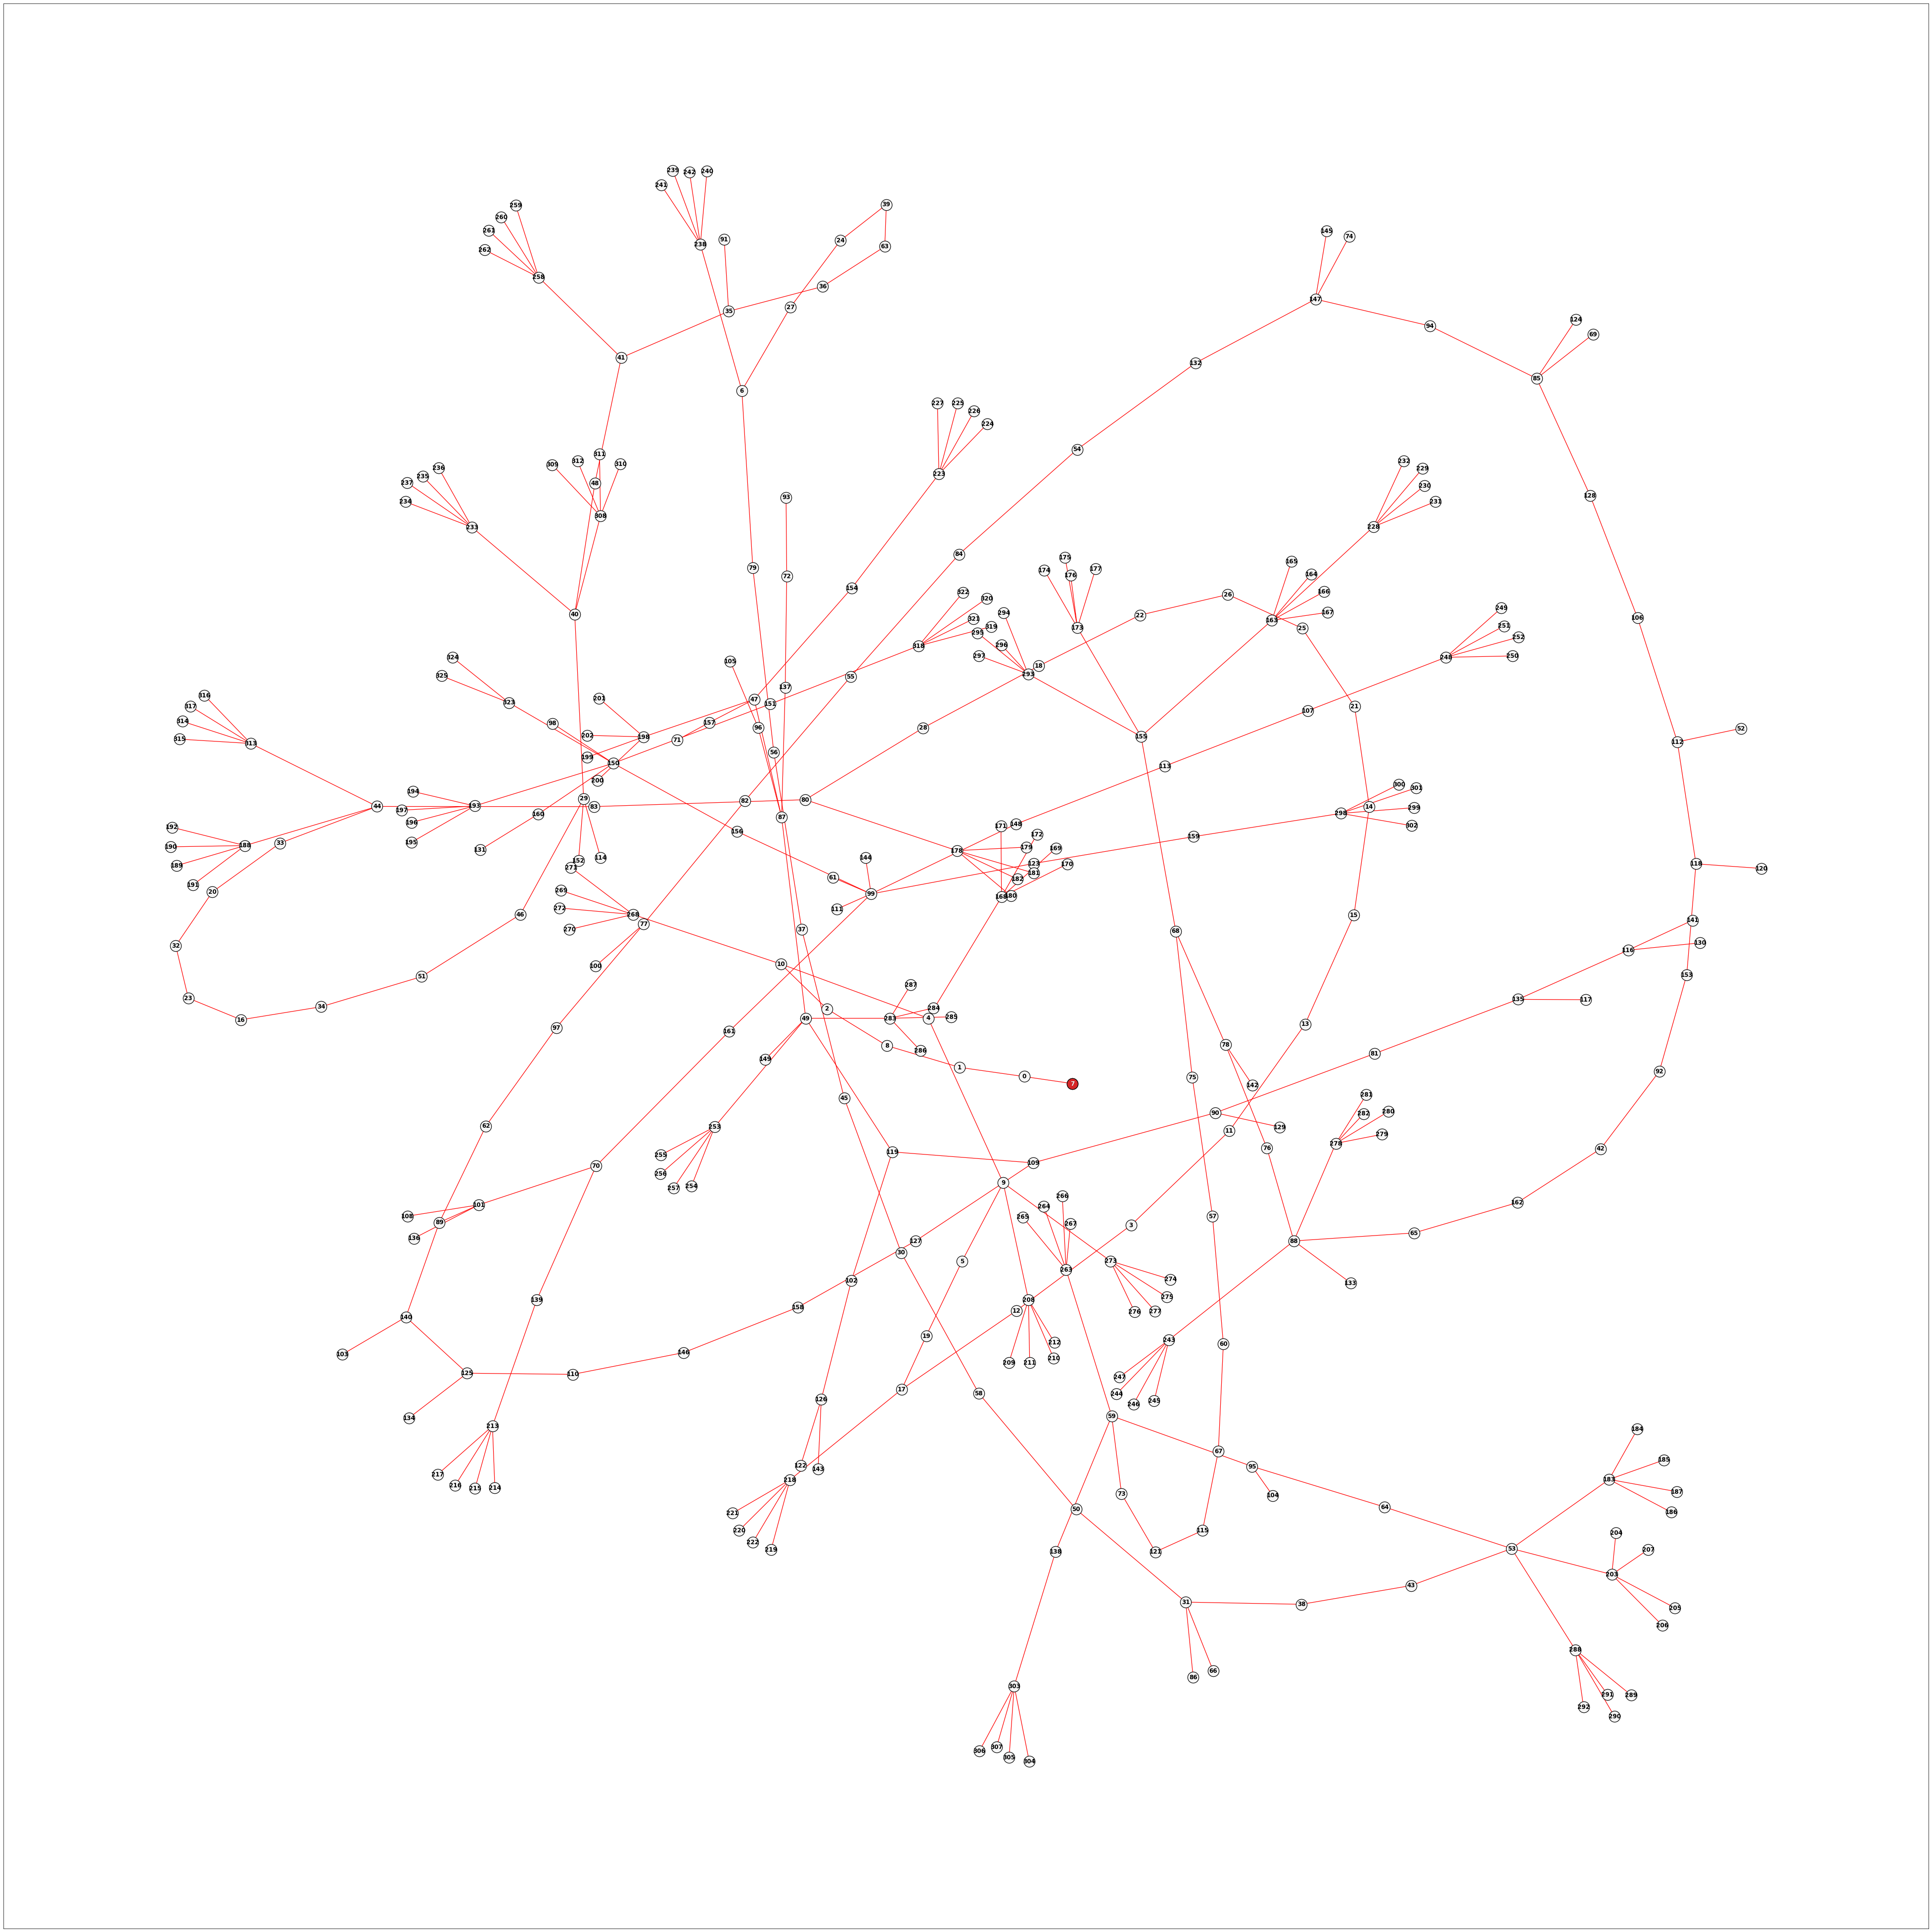

In [9]:
# RENDERING MST INIZIALE
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_initial")

### 2. Improvement

Ad ogni iterazione memorizza in una lista tabu l’inversa della mossa appena effettuata, che resterà proibita per le prossime `TABU_SIZE` iterazioni.

Garantisce che un arco inserito in soluzione con un'operazione di scambio possa essere rimosso solo su una soluzione ormai sostanzialmente diversa da quella originata dalla mossa che l'ha inserito. In questo modo la ricerca non torna facilmente sui suoi passi.

In [10]:
# PARAMETRI RICERCA
TABU_SIZE = 50      
MAX_ITER = 36000            # arresta la ricerca dopo queste iterazioni (es. se il grafo è troppo grosso)
MAX_ITER_SAME_COST = 600    # max. iterazioni su uno stallo

# [Debug]
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False    

In [11]:
# TABU SEARCH
start_time = time.time()
results = tabu_search(G, start_solution=mst, ROOT_NODE=ROOT_NODE, 
                        TABU_SIZE=TABU_SIZE, 
                        MAX_ITER=MAX_ITER, MAX_ITER_SAME_COST=MAX_ITER_SAME_COST)
end_time = time.time()

mst = results["solution"]
iter = results["elapsed_iterations"]
iters_since_last_improvement = results["since_last_improvement_iterations"]

### 3. Risultati


In [12]:
# PRINT RESULTS
print("Costo finale: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)

print("")
print("---DETTAGLI---")
print("Iterazioni complessive eseguite: {}/{}".format(iter,MAX_ITER))
print("Iterazioni eseguite dall'ultimo miglioramento di funzione obiettivo: {}/{}".format(iters_since_last_improvement ,MAX_ITER_SAME_COST))
print("Stallo raggiunto: ", iters_since_last_improvement >= MAX_ITER_SAME_COST)
print("Nodi non ottimali (nodo: n. figli): ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("Generatore: ",GRAPH_GENERATOR)
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("grafo è non completo: ", not (E == V*(V-1)/2))

print("soluzione è un albero: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("cicli in soluzione: ", cycletest)


Costo finale:  129
MST =  [(7, 152), (0, 86), (0, 3), (0, 139), (0, 153), (0, 1), (1, 122), (8, 143), (8, 93), (2, 143), (2, 73), (10, 268), (10, 144), (4, 168), (4, 103), (9, 208), (9, 273), (9, 128), (5, 114), (5, 141), (19, 23), (19, 138), (17, 218), (17, 91), (12, 6), (12, 145), (3, 142), (11, 100), (11, 161), (13, 151), (13, 160), (15, 100), (15, 79), (14, 52), (14, 130), (21, 25), (21, 61), (25, 121), (26, 117), (26, 22), (22, 66), (18, 152), (18, 33), (28, 104), (28, 80), (80, 178), (83, 20), (83, 91), (83, 156), (44, 188), (44, 313), (44, 111), (33, 114), (20, 64), (32, 23), (32, 86), (16, 110), (16, 131), (34, 51), (34, 116), (51, 46), (46, 158), (29, 148), (29, 149), (40, 48), (40, 233), (40, 308), (48, 150), (41, 258), (41, 156), (35, 105), (35, 136), (36, 63), (36, 143), (63, 39), (63, 111), (39, 27), (24, 133), (24, 74), (27, 109), (6, 238), (79, 56), (79, 144), (56, 155), (37, 45), (37, 130), (45, 31), (30, 58), (30, 71), (58, 50), (50, 69), (31, 66), (38, 146), (38, 154)

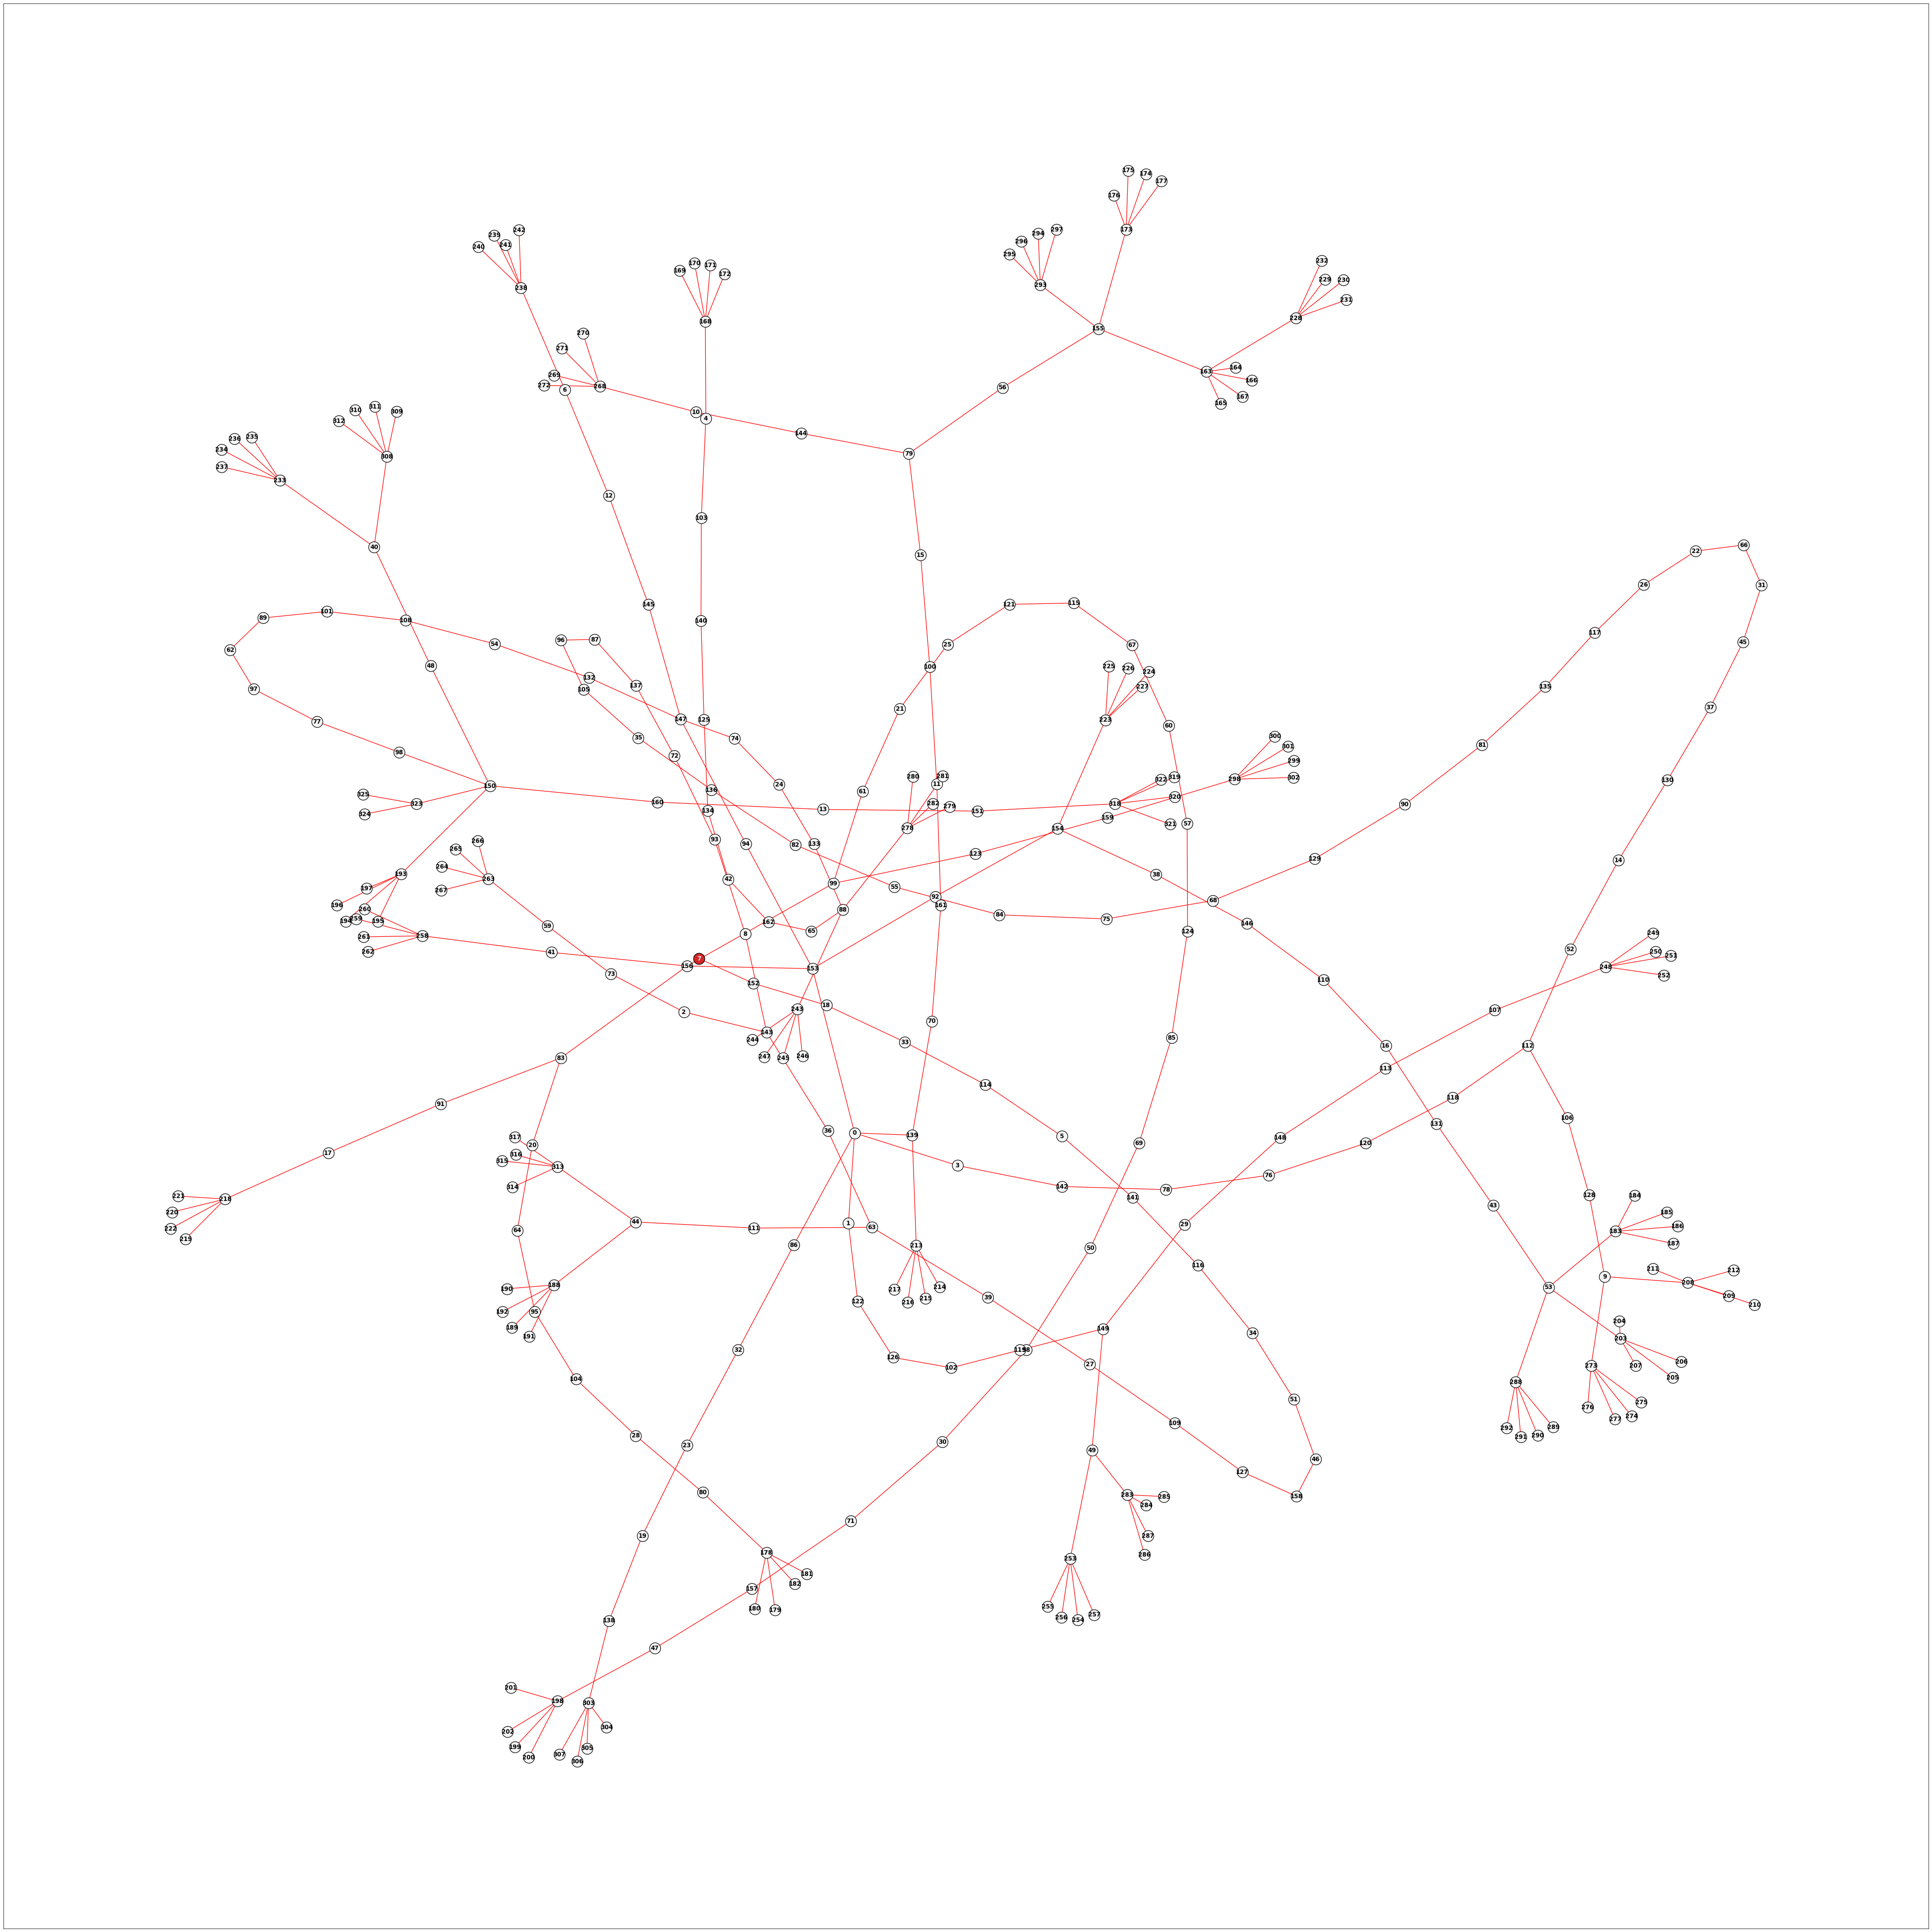

In [13]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

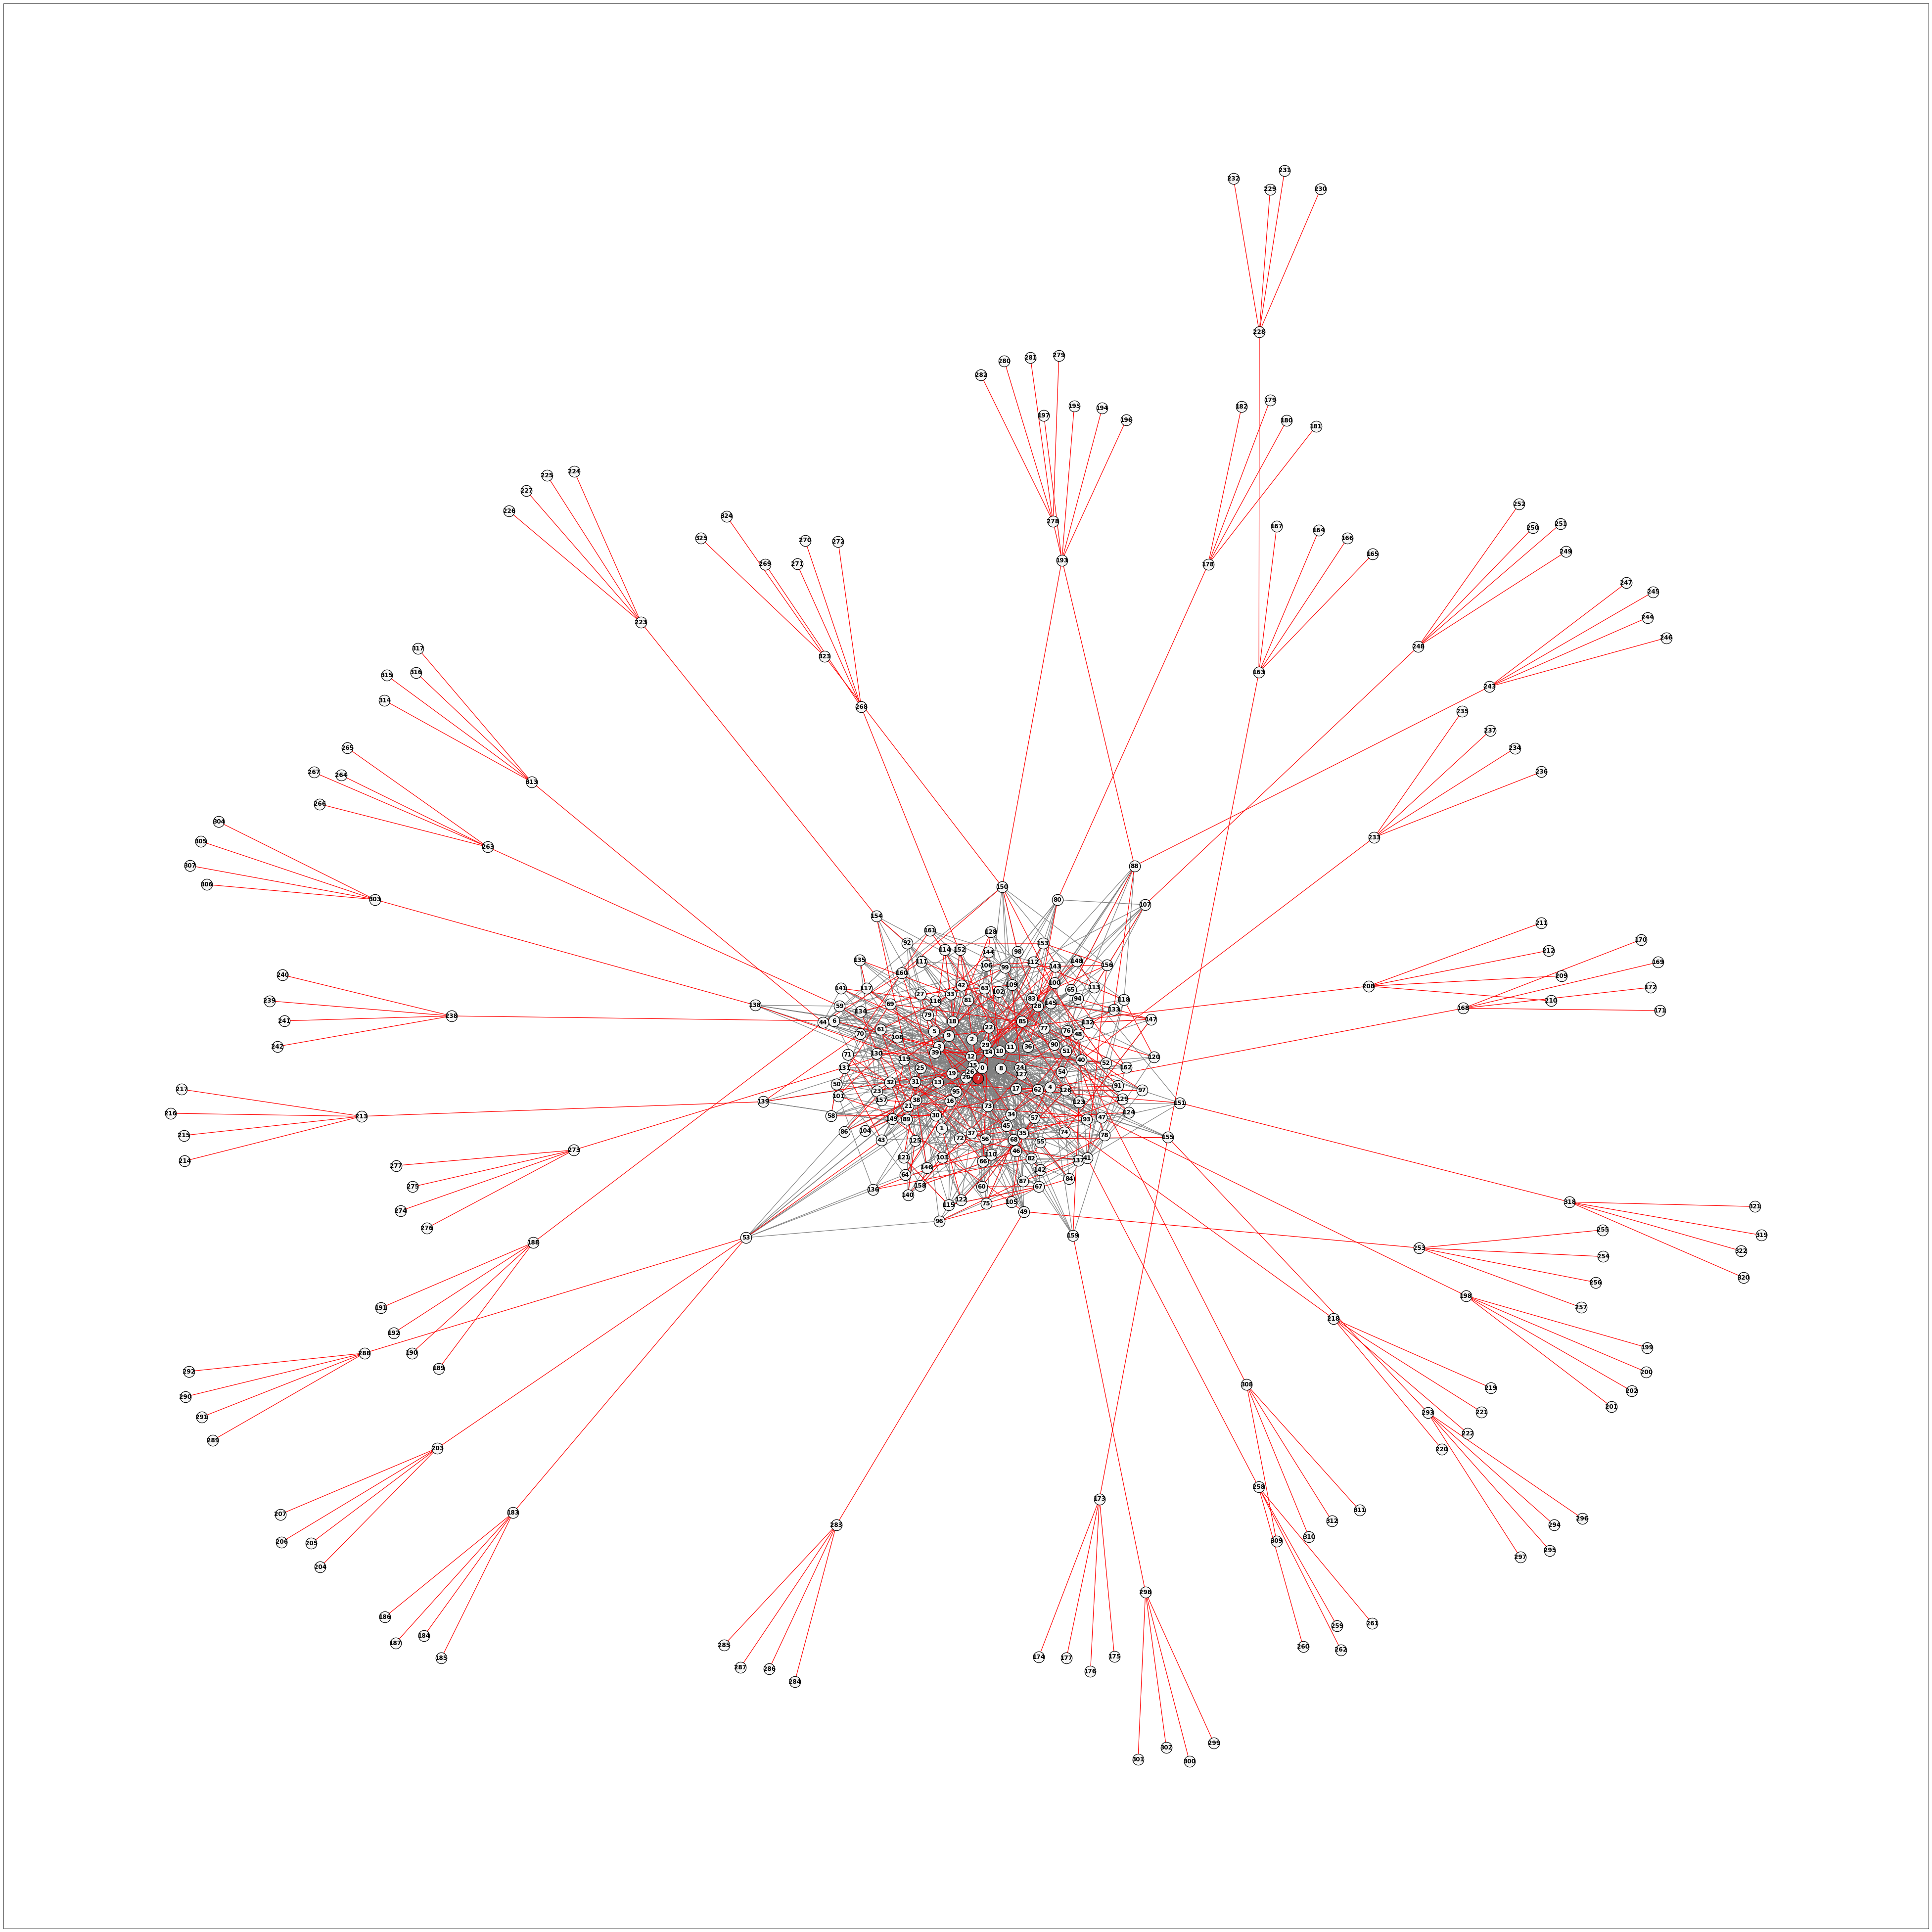

In [14]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")

In [15]:
# Notifica completamento
from plyer import notification

notification_message = """
Found a solution with cost {}
Elapsed time: {:.2f}s
Iterations completed: {}/{}

""".format(
        cost(mst, ROOT_NODE),
        (end_time-start_time),
        iter, MAX_ITER,OUT_DIR
    )

notification.notify(
    title="MST computation finished",
    message=notification_message,
    app_name="ProgettoRO",
    #app_icon="python.exe",
    timeout=15
)